# Introduction

### What is BERT?

BERT (Bidirectional Encoder Representations from Transformers), released in late 2018, is the model we will use in this tutorial to provide readers with a better understanding of and practical guidance for using transfer learning models in NLP. BERT is a method of pretraining language representations that was used to create models that NLP practicioners can then download and use for free. You can either use these models to extract high quality language features from your text data, or you can fine-tune these models on a specific task (classification, entity recognition, question answering, etc.) with your own data to produce state of the art predictions.


### Why BERT embeddings?

We will use BERT to extract features, namely word and sentence embedding vectors, from text data. What can we do with these word and sentence embedding vectors? First, these embeddings are useful for keyword/search expansion, semantic search and information retrieval. For example, if you want to match customer questions or searches against already answered questions or well documented searches, these representations will help you accuratley retrieve results matching the customer's intent and contextual meaning, even if there's no keyword  or phrase overlap.

Second, and perhaps more importantly, these vectors are used as high-quality feature inputs to downstream models. NLP models such as LSTMs or CNNs require inputs in the form of numerical vectors, and this typically means translating features like the vocabulary and parts of speech into numerical representations. In the past, words have been represented either as uniquely indexed values (one-hot encoding), or more helpfully as neural word embeddings where vocabulary words are matched against the fixed-length feature embeddings that result from models like Word2Vec or Fasttext. BERT offers an advantage over models like Word2Vec, because while each word has a fixed representation under Word2Vec regardless of the context within which the word appears, BERT produces word representations that are dynamically informed by the words around them. For example, given two sentences:

"The man was accused of robbing a bank."
"The man went fishing by the bank of the river."

Word2Vec would produce the same word embedding for the word "bank" in both sentences, while under BERT the word embedding for "bank" would be different for each sentence. Aside from capturing obvious differences like polysemy, the context-informed word embeddings capture other forms of information that result in more accurate feature representations, which in turn results in better model performance.

# 1. Loading Pre-Trained BERT

Install the pytorch interface for BERT by Hugging Face. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) 

We've selected the pytorch interface because it strikes a nice balance between the high-level APIs (which are easy to use but don't provide insight into how things work) and tensorflow code (which contains lots of details but often sidetracks us into lessons about tensorflow, when the purpose here is BERT!).

In [ ]:
pip install transformers

     |████████████████████████████████| 2.0MB 8.2MB/s 
     |████████████████████████████████| 3.2MB 37.2MB/s 
     |████████████████████████████████| 890kB 40.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=c2853c4fb72075edc876c97c20c18347b3d12f96857c076a21848b28e24c773b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Now let's import pytorch, the pretrained BERT model, and a BERT tokenizer.

transformers provides a number of classes for applying BERT to different tasks (token classification, text classification, ...). Here, we're using the basic BertModel which has no specific output task--it's a good choice for using BERT just to extract embeddings.

In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import math

import numpy as np

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
% matplotlib inline

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Install pysubparser to read the srt files

In [ ]:
pip install pysub-parser

     |████████████████████████████████| 245kB 7.3MB/s 


Import stuff

In [ ]:
from pysubparser import parser
from pysubparser.cleaners import brackets, lower_case, formatting
import datetime

Read srt file

In [ ]:
subtitles = parser.parse(
    "/content/sample_data/0003.srt")

subtitles = brackets.clean(
    lower_case.clean(
        formatting.clean(
            subtitles
        )
    )
)

start_times = []
sentences = []
for sub in subtitles:
  sentences.append(sub.text)
  start_times.append(sub.start)

gt_file = open(
    "/content/sample_data/0003.txt", "r")
gt_file_content = gt_file.read().split("\n")
gt_start_times = []
for fc in gt_file_content:
    st_time = fc.split("\t")
    if (len(st_time) > 1):
        gt_start_times.append(
            datetime.datetime.strptime(st_time[1], "%H:%M:%S,%f"))
gt_file.close()

# 2. Input Formatting
Because BERT is a pretrained model that expects input data in a specific format, we will need:

1. A **special token, `[SEP]`,** to mark the end of a sentence, or the separation between two sentences
2. A **special token, `[CLS]`,** at the beginning of our text. This token is used for classification tasks, but BERT expects it no matter what your application is. 
3. Tokens that conform with the fixed vocabulary used in BERT
4. The **Token IDs** for the tokens, from BERT's tokenizer
5. **Mask IDs** to indicate which elements in the sequence are tokens and which are padding elements
6. **Segment IDs** used to distinguish different sentences
7. **Positional Embeddings** used to show token position within the sequence

## 2.1. Special Tokens
BERT can take as input either one or two sentences, and uses the special token `[SEP]` to differentiate them. The `[CLS]` token always appears at the start of the text, and is specific to classification tasks. 

Both tokens are *always required*, however, even if we only have one sentence, and even if we are not using BERT for classification. That's how BERT was pre-trained, and so that's what BERT expects to see.

**2 Sentence Input**:

`[CLS] The man went to the store. [SEP] He bought a gallon of milk.`

**1 Sentence Input**:

`[CLS] The man went to the store. [SEP]`



## 2.2. Tokenization

BERT provides its own tokenizer, which we imported above.

## 2.3. Segment ID
BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in "tokenized_text," we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, single-sentence inputs only require a series of 1s, so we will create a vector of 1s for each token in our input sentence. 

If you want to process two sentences, assign each word in the first sentence plus the '[SEP]' token a 0, and all tokens of the second sentence a 1.

In [ ]:
def tokenize_text(input_text):
  marked_text = "[CLS] " + input_text + " [SEP]"

  tokenized_text = tokenizer.tokenize(marked_text)
  indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
  segment_ids = [1] * len(tokenized_text)

  return tokenized_text, indexed_tokens, segment_ids

# 3. Extracting Embeddings 

## 3.1. Running BERT on our text


Next we need to convert our data to torch tensors and call the BERT model. The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.
 


In [ ]:
tokenized_text, indexed_tokens, segment_ids = tokenize_text(sentences[2])

tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segment_ids])

print(tokens_tensor)

tensor([[  101,  2070,  6887, 16515,  3549, 10091,   102]])


Calling `from_pretrained` will fetch the model from the internet. When we load the `bert-base-uncased`, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers! Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [ ]:
# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-base-uncased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor, segments_tensors)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## 3.2. Understanding the Output

The full set of hidden states for this model, stored in the object `hidden_states`, is a little dizzying. This object has four dimensions, in the following order:

1. The layer number (13 layers)
2. The batch number (1 sentence)
3. The word / token number (22 tokens in our sentence)
4. The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn't BERT only have 12? It's 13 because the first element is the input embeddings, the rest is the outputs of each of BERT's 12 layers. 

That’s 219,648 unique values just to represent our one sentence! 

The second dimension, the batch size, is used when submitting multiple sentences to the model at once;

In [ ]:
print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0

print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0

print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0

print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 7
Number of hidden units: 768


In [ ]:
def rearrange_tensor(tensor):
  # Concatenate the tensors for all layers. We use `stack` here to
  # create a new dimension in the tensor.
  token_embeddings = torch.stack(tensor, dim=0)

  # Remove dimension 1, the "batches".
  token_embeddings = torch.squeeze(token_embeddings, dim=1)

  # Swap dimensions 0 and 1.
  token_embeddings = token_embeddings.permute(1,0,2)

  return token_embeddings

rearranged = rearrange_tensor(hidden_states)
print(rearranged.size())

torch.Size([7, 13, 768])


## 3.3. Creating sentence vectors from hidden states

To get a single vector for our entire sentence we have multiple application-dependent strategies, but a simple approach is to average the second to last hiden layer of each token producing a single 768 length vector.



In [ ]:
# `hidden_states` has shape [13 x 1 x n x 768]

# `token_vecs` is a tensor with shape [n x 768]
token_vecs = hidden_states[-2][0]

# Calculate the average of all n token vectors.
sentence_embedding = torch.mean(token_vecs, dim=0)

print ("Our final sentence embedding vector of shape:", sentence_embedding.size())

Our final sentence embedding vector of shape: torch.Size([768])


Calculate Cosine Similarity

In [ ]:
from scipy.spatial.distance import cosine

diff = 1 - cosine(sentence_embedding, sentence_embedding)

print(diff)

1.0


# Video Fragmentation

From this point on we take the sentences and concatenate them to form strings of a fixed length *n*. We call these strings "windows" and we increment each window with a step size of *n/12*.

*   After building the windows, we use the Universal Sentence Encoder to generate word embeddings for each string.
*   We then use these embeddings to calculate the cosine similarity between two consecutive windows.
*   The cosine similarity values are then plotted on a line chart which helps us understand the semantic similarity between consecutive windows.
*   The local minimas at every point are where the previous and next segments are the least related, and they are taken as a candidate where we can segment the video
*   Out of all the minimas, we pick the best points under a given threshold and evaluate them
*   depth = peak value(left) + peak value(right)
*   mew = np.mean(depths)
*   sigma = np.std(depths)
*   threshold = m * (mew - sigma)



Window size:  120 Step size:  10
Threshold:  1.4856626799632013
no of boundaries 58
Boundary 		 Actual Start Time 	 Difference in Seconds:
1900-01-01 00:07:34.920000	1900-01-01 00:07:23.750000	11.17
1900-01-01 00:13:29.540000	1900-01-01 00:13:12.470000	17.07
1900-01-01 00:18:34.570000	1900-01-01 00:18:18.110000	16.46
1900-01-01 00:30:45.080000	1900-01-01 00:31:01.200000	16.12
1900-01-01 00:44:34.850000	1900-01-01 00:44:29.720000	5.13
1900-01-01 00:50:21.600000	1900-01-01 00:50:25.030000	3.43
1900-01-01 00:54:37.240000	1900-01-01 00:54:41.640000	4.4
1900-01-01 01:00:01.070000	1900-01-01 00:59:18.160000	42.91
1900-01-01 01:02:18.360000	1900-01-01 01:02:29.840000	11.48
1900-01-01 01:09:01.260000	1900-01-01 01:08:13.470000	47.79
1900-01-01 01:13:57.890000	1900-01-01 01:13:48.150000	9.74
1900-01-01 01:20:14.940000	1900-01-01 01:20:04.770000	10.17
1900-01-01 01:25:28.720000	1900-01-01 01:24:57.790000	30.93
1900-01-01 01:30:25.720000	1900-01-01 01:30:54.260000	28.54
1900-01-01 01:35:00.20000

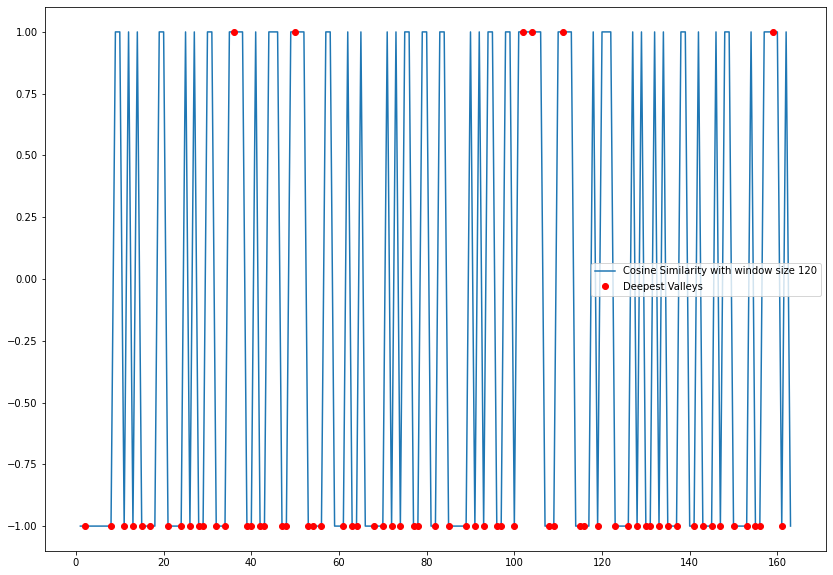

In [ ]:
def build_sliding_window(init_times, sequence, window_size, step_size):
  req_chunks = []
  req_window_start_times = []
  curr_window_start = 0
  curr_window_end = step_size
  # print(len(init_times))
  while (curr_window_end <= len(sequence)):
    req_chunks.append(sequence[curr_window_start : curr_window_end])
    req_window_start_times.append(init_times[curr_window_start])
    curr_window_start += step_size
    curr_window_end += step_size
 
  return req_chunks, req_window_start_times
 
 
def normalise_chunks(sentence_chunks):
  sentences = []
  for chunk in sentence_chunks:
    sentences.append(chunk[0])
  return sentences
 
 
def plot_fig(x, score, heading, fig_no, can_plot):
  if can_plot:
    fig = plt.figure(fig_no, figsize=(14, 10))
    ax = fig.add_subplot(111)
    ax.plot(x, score, label=heading)
 
  score_arr = np.array(score)
  x_arr = np.array(x)
  b = (np.diff(np.sign(np.diff(score_arr))) > 0).nonzero()[0] + 1  # Local minimas
 
  prev_index = 0
  peak_values = []
  for minima_index in range(0, len(b) - 1):
    peak_left = -1
    for left_val in range(prev_index, b[minima_index]):
      if (score_arr[left_val] > peak_left):
        peak_left = score_arr[left_val]
 
    peak_right = -1
    for right_val in range(b[minima_index], b[minima_index + 1]):
      if (score_arr[right_val] > peak_right):
        peak_right = score_arr[right_val]
 
    prev_index = b[minima_index]
    peak_values.append((peak_left, peak_right))
 
  depth_values = []
  for i in range(0, len(peak_values)):
    depth_val = (peak_values[i][0] - score_arr[b[i]]) + (peak_values[i][1] - score_arr[b[i]])
    depth_values.append((depth_val, b[i]))
 
  if can_plot:
    ax.plot(x_arr[b], score_arr[b], "o", label="Deepest Valleys", color='r')
    ax.legend()
 
  return b, depth_values
 
def embed(sentence_list):
  embeddings = []
  for sentence in sentence_list:
    local_tokenized_text, local_indexed_tokens, local_segment_ids = tokenize_text(sentence)
    local_tokens_tensor = torch.tensor([indexed_tokens])
    local_segments_tensors = torch.tensor([segment_ids])
    with torch.no_grad():
      outputs = model(tokens_tensor, segments_tensors)
      hidden_states = outputs[2]
      token_vecs = hidden_states[-2][0]
      sent_embedding = torch.mean(token_vecs, dim=0)
      embeddings.append(sent_embedding)
 
  return embeddings
 
def vectorise(sentences, sentence_len, fig_no):
  sentence_embeddings = embed(sentences)
  score = []
  for i in range(0, len(sentence_embeddings) - 2):
    diff = 1 - cosine(sentence_embedding[i:i+1][0], sentence_embedding[i+1:i+2][0])
    score.append(diff)
  # Plotting Cosine Similarity
  minimas, depth_values = plot_fig(range(1, len(sentence_embeddings) - 1), score,
                      'Cosine Similarity with window size ' + str(sentence_len), fig_no, True)
  return score, minimas, depth_values
 
 
def get_best_points(messages, minimas, window_start_times, depth_values):
  selected_windows = []
  cos_sim_values = []
  for minima_pair in minimas:
    cos_sim_values.append(np.float(minima_pair[0]))
 
  m = 1.414
  depths = []
  for d in depth_values:
    depths.append(d[0])
  mew = np.mean(depths)
  sigma = np.std(depths)
  threshold = m * (mew - sigma)
  print("Threshold: ", threshold)
 
  for d_val in depth_values:
    if (d_val[0] > threshold):
      selected_windows.append(window_start_times[d_val[1]])
 
  # print(len(selected_windows))
  return selected_windows
 
 
window_size = 120
step_size = window_size // 12
print("\nWindow size: ", window_size, "Step size: ", step_size)
 
chunks, window_start_times = build_sliding_window(start_times, sentences, window_size, step_size)
messages = normalise_chunks(chunks)
 
# vectorising
cos_sim_scores, loc_minimas, depth_values = vectorise(messages, window_size, 1)
 
minimas = []
for i in loc_minimas:
  minimas.append((cos_sim_scores[i], i))
 
boundaries = get_best_points(messages, minimas, window_start_times, depth_values)
 
# for b in boundaries:
#   print(b)
 
print("no of boundaries " + str(len(boundaries)))
pos_predictions = 0
 
# output_file = open("./output.txt", "a")
# output_file.write("\nWindow size: " + str(window_size) + " Step size: " + str(step_size))
print("Boundary \t\t Actual Start Time \t Difference in Seconds:")
for i in range(0, len(gt_start_times)):
  min_diff = 999
  boundary_date = ""
  for j in range(0, len(boundaries)):
    dt = datetime.datetime.combine(datetime.date(1900, 1, 1), boundaries[j])
    diff = gt_start_times[i] - dt
    if (abs(diff.total_seconds()) <= 60):
      if (abs(diff.total_seconds()) < min_diff):
        min_diff = abs(diff.total_seconds())
        boundary_date = dt
 
  if (min_diff <= 30):
    pos_predictions += 1
    # output_file.write("\nboundary: " + str(boundary_date))
    # output_file.write("\tactual start time: " + str(gt_start_times[i]))
    # output_file.write("\tdifference in seconds: " + str(min_diff))
    print(str(boundary_date)+"\t"+str(gt_start_times[i])+"\t"+str(min_diff))
    #print("\nboundary: " + str(boundary_date))
    #print("actual start time: " + str(gt_start_times[i]))
    #print("difference in seconds: " + str(min_diff))
 
print("Number of segments predicted: " + str(pos_predictions))
print("no. of actual segments: " + str(len(gt_start_times)))
# output_file.write("\nNumber of segments predicted: " + str(pos_predictions))
p = pos_predictions / len(boundaries)
r = pos_predictions / len(gt_start_times)
divider = p + r
if (divider == 0):
  divider = 1
f = (2 * p * r) / divider
print("\nPrecision: " + str(p), "Recall: " + str(r), "F-Score: " + str(f))
# output_file.write("\nPrecision: " + str(p) + "Recall: " + str(r) + "F-Score: " + str(f))
# output_file.close()